# ВВЕДЕНИЕ

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

Этапы проекта:
1) Загрузка и изучение данных

2) Предобработка и исследовательский анализ

3) Объединение данных

4) Исследовательский и кореляционный анализ

5) Подготовка данных для МО

6) Обучение моделей

7) Выбор лучшей модели

In [1]:
!pip install shap -q
!pip install phik -q
!pip install catboost -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.8 MB/s eta 0:00:00


In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import phik

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import  SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,  RobustScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.preprocessing import QuantileTransformer
from sklearn.inspection import permutation_importance
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
import transformers


In [3]:
def create_boxplot_and_hist(data, columns):
    for i in data[columns].columns:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
        axes[0].hist(data[i], bins=30)
        axes[0].set_title('Гистограмма распределения')
        axes[0].set_xlabel(i)

        axes[1].boxplot(data[i])
        axes[1].set_xlabel(i)
        axes[1].set_title('Ящик с усами')
        plt.show()

In [4]:
#def create_pie(data, columns):
#    for i in data[columns].columns:
#        df = data.groupby(i).count()
#        fig, ax = plt.subplots(figsize=(8,8), facecolor='#e8f4f0')
#        ax.pie(df[df.columns[-1]], labels=df.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'), labeldistance=0.5)
#        ax.set_title('Круговая диаграмма')
#        ax.set_xlabel(i)

In [5]:
def create_pie(data, columns):
    plt.figure(figsize=(20, 15))
    plt.subplots_adjust(hspace=0.3)
    #plt.suptitle("", fontsize=15, y=0.95)

    # set number of columns (use 3 to demonstrate the change)
    ncols = 3
    # calculate number of rows
    nrows = len(columns) // ncols + (len(columns) % ncols > 0)

    # loop through the length of tickers and keep track of index
    for n, ticker in enumerate(columns):
        # add a new subplot iteratively using nrows and cols
        ax = plt.subplot(nrows, ncols, n + 1)

        # filter df and plot ticker on the new subplot axis

        df = data.groupby(ticker).count()
        #fig, ax = plt.subplots(figsize=(8,8), facecolor='#e8f4f0')
        ax.pie(df[df.columns[-1]], labels=df.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))


        # chart formatting
        ax.set_title(ticker.upper())
        #ax.get_legend().remove()
        ax.set_xlabel("")

In [6]:
def cat_num_col(df):
    num_col_names = list(df.select_dtypes(include=['int64', 'float64']).columns)
    cat_col_names = list(df.select_dtypes(include=['object']).columns)
    cat_col_names.remove('customerID')
    return num_col_names, cat_col_names

In [7]:
def plot_phik_heatmap(df, interval_cols):
    # Вычисление phik_matrix
    phik_matrix = df.phik_matrix(interval_cols=interval_cols)

    # Использование цветовой карты RdYlBu для лучшей визуализации
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Создание тепловой карты на основе phik_matrix
    plt.figure(figsize=(15, 10))
    sns.heatmap(phik_matrix, annot=True, cmap=cmap, center=0, square=True, linewidths=.5)
    plt.title('Phik. Тепловая карта')
    plt.show()

In [8]:
def evaluate_pipeline(pipeline, param_grid, X_train, y_train):
    #start_time = time()

    grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=5, scoring='roc_auc')

    grid_search.fit(X_train, y_train)

    #pipeline.fit(X_train, y_train)

    #end_time = time()
    #execution_time = end_time - start_time
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    roc_auc_score = grid_search.best_score_

    #start_prediction_time = time()
    #predictions = best_model.predict(X_train)
    #end_prediction_time = time()
    #prediction_time = end_prediction_time - start_prediction_time

    return best_params, roc_auc_score, best_model

## Загрузка данных

In [9]:
try:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')
except FileNotFoundError:
    print('Ошибка')

In [10]:
display(contract.head())
display(personal.head())
display(internet.head())
display(phone.head())


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [11]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Датафрейм contact содержит 7043 записи и 8 признаков:
- customerID - идентификатор абонента
- BeginDate - дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

In [12]:
personal.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Датафрейм personal содержит 7043 записи и 5 признаков:
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Датафрейм internet сорержит 5517 записей и 8 признаков:
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

In [14]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Датафрейм phone содержит 6361 записей и 2 признака:
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

**Вывод** В качестве данных у нас 4 датафрейма с данными о договоре, персональных данных клиентов, информацией об интернет-услугах и информацией об услугах телефонии. В данных нет пропусков и все данных соотвествуют тем, что были даны в описании к названиям колонок (кроме TotalCharges, далее изменит его тип данных на float)

## Исследовательский анализ и предобработка данных

### Исследовательский анализ contract

Изменим тип данных признака 'TotalCharges' на float и заменим пустые значения нулями, тк скорей скорей всего пропуск значит, что клиент заключил контракт, но еще не оплатил

In [15]:
contract.loc[contract['TotalCharges'] == ' '].head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,


In [16]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = 0
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

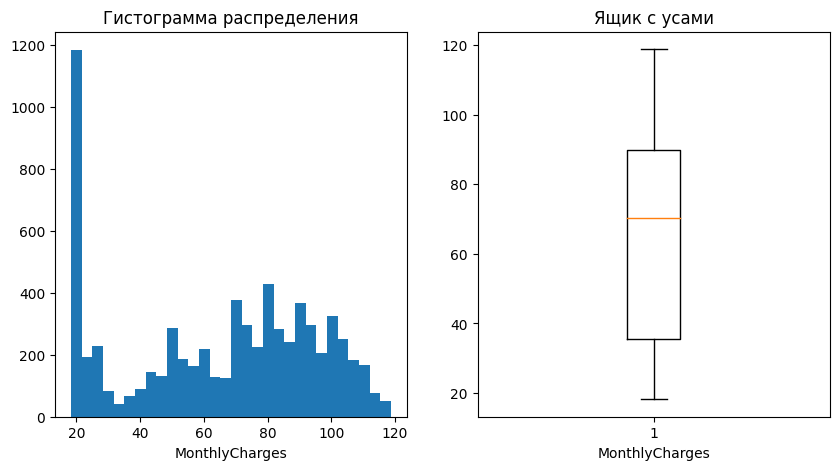

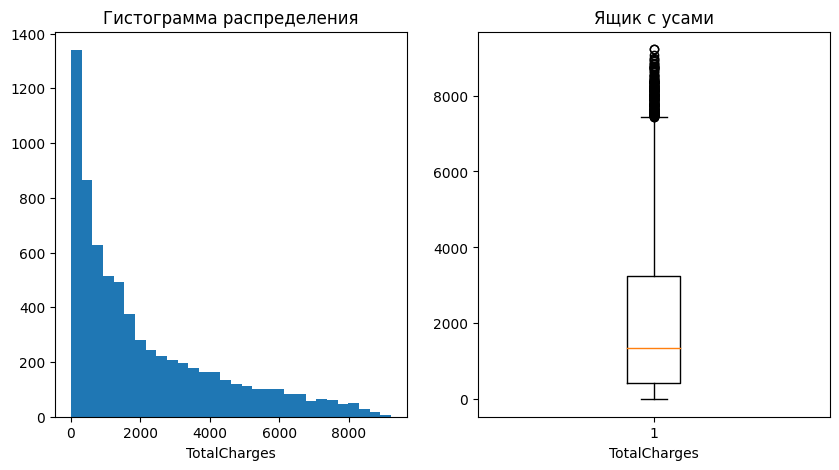

In [17]:

num_col_contract, cat_col_contract = cat_num_col(contract)
create_boxplot_and_hist(contract, num_col_contract)

In [18]:
contract.query('TotalCharges > 7500').head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
17,9959-WOFKT,2014-03-01,No,Two year,No,Bank transfer (automatic),106.70,8257.51
57,5067-XJQFU,2014-08-01,No,One year,Yes,Electronic check,108.45,7730.32
59,5954-BDFSG,2014-02-01,No,Two year,Yes,Credit card (automatic),107.50,7740.00
198,7255-SSFBC,2014-02-01,No,Two year,Yes,Bank transfer (automatic),112.25,8324.46
369,3520-FJGCV,2014-02-01,No,Two year,Yes,Credit card (automatic),112.60,8755.78
437,4376-KFVRS,2014-02-01,No,Two year,Yes,Credit card (automatic),114.05,8211.60
449,1090-ESELR,2014-02-01,No,Two year,No,Bank transfer (automatic),105.50,7596.00
464,1480-BKXGA,2014-02-01,No,Two year,Yes,Bank transfer (automatic),116.05,8355.60
483,5168-MQQCA,2014-02-01,No,One year,Yes,Bank transfer (automatic),108.50,8358.84
526,8606-CIQUL,2014-02-01,No,Two year,Yes,Credit card (automatic),115.75,8334.00


По графику видим выбросы в столбце TotalCharges, но видно, что дата начала договора у всех началась 6 лет назад, поэтому это вполне реальные значения. Удалять не будем

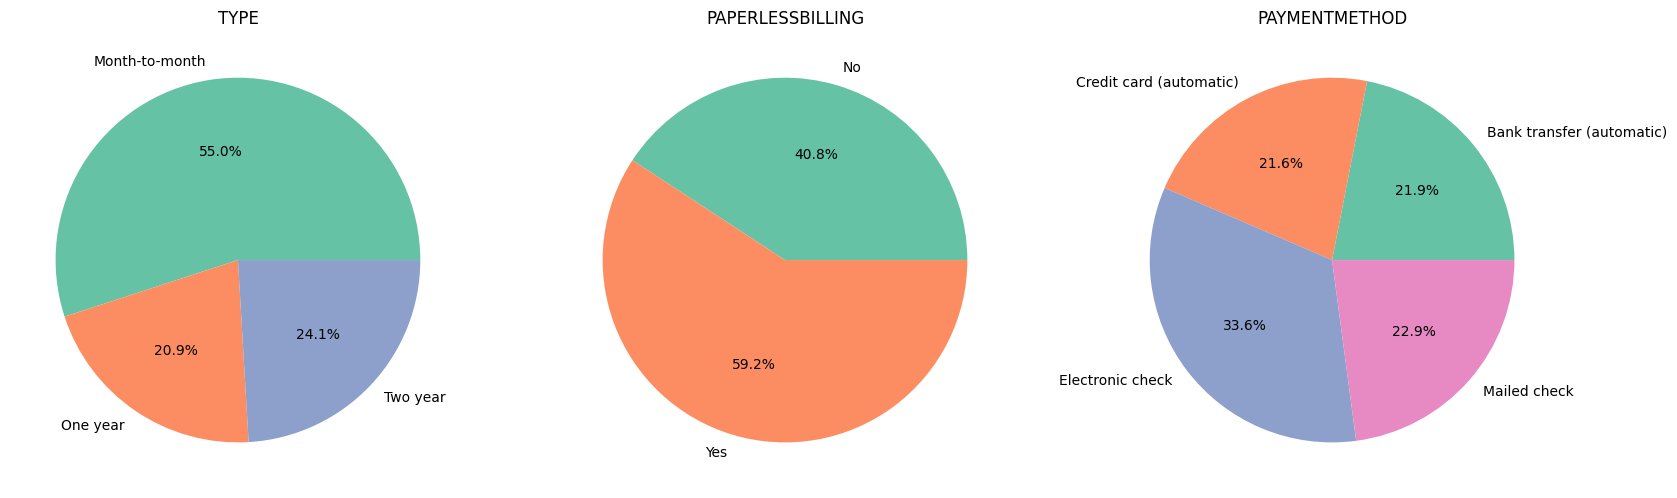

In [19]:
create_pie(contract, cat_col_contract[2:])

По графикам видно:
- более половины (55%) клиентов пользуются помесячной оплатой
- 59% предпочитаю электронный чек
- Распределение типов платежа примерно одинаковое, электронный расчет немного доминирует (34%)

### Исследовательский анализ personal

In [20]:
personal = personal.astype({'SeniorCitizen': 'str'})

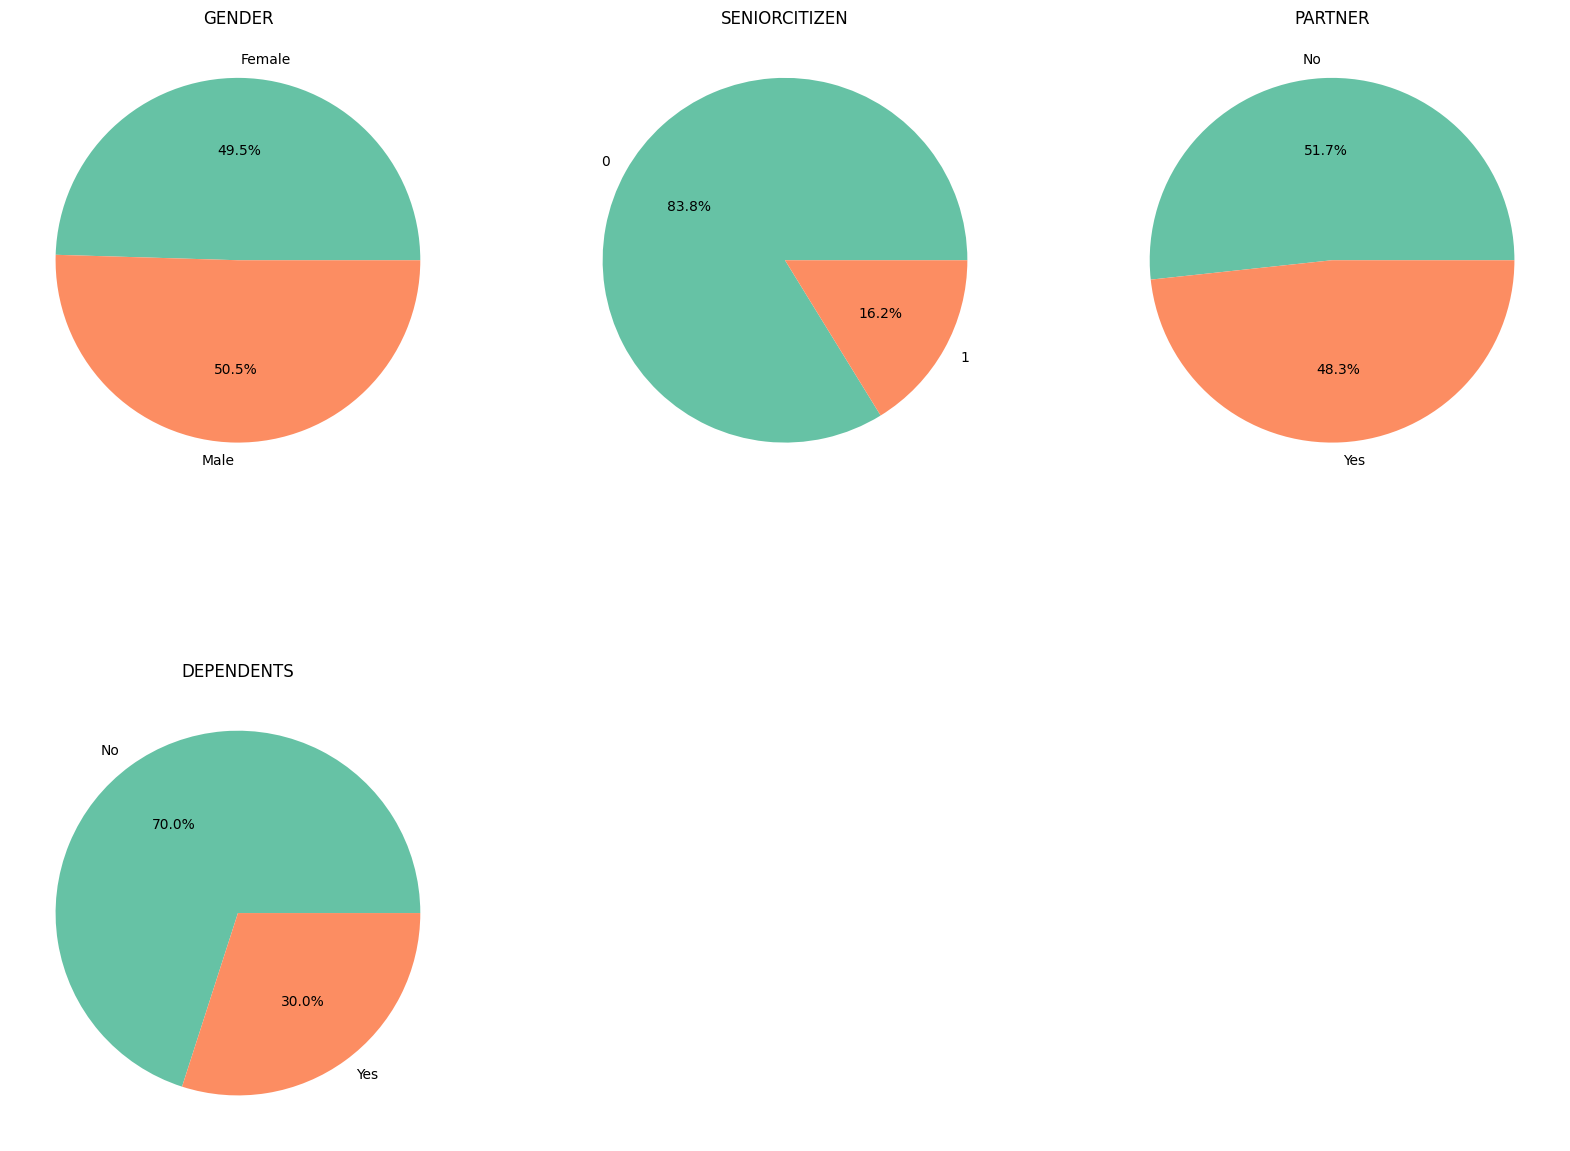

In [21]:
create_pie(personal, ['gender', 'SeniorCitizen', 'Partner', 'Dependents'])

По графикам видно:
- Количество клиентов мужского и женского пола практически одинаково
- 16% из всех пользователей являются пенсионеры
- также половина пользователей холостые
- 70% клиентов не имею детей


### Исследовательский анализ internet

In [22]:
num_col_internet, cat_col_internet = cat_num_col(internet)

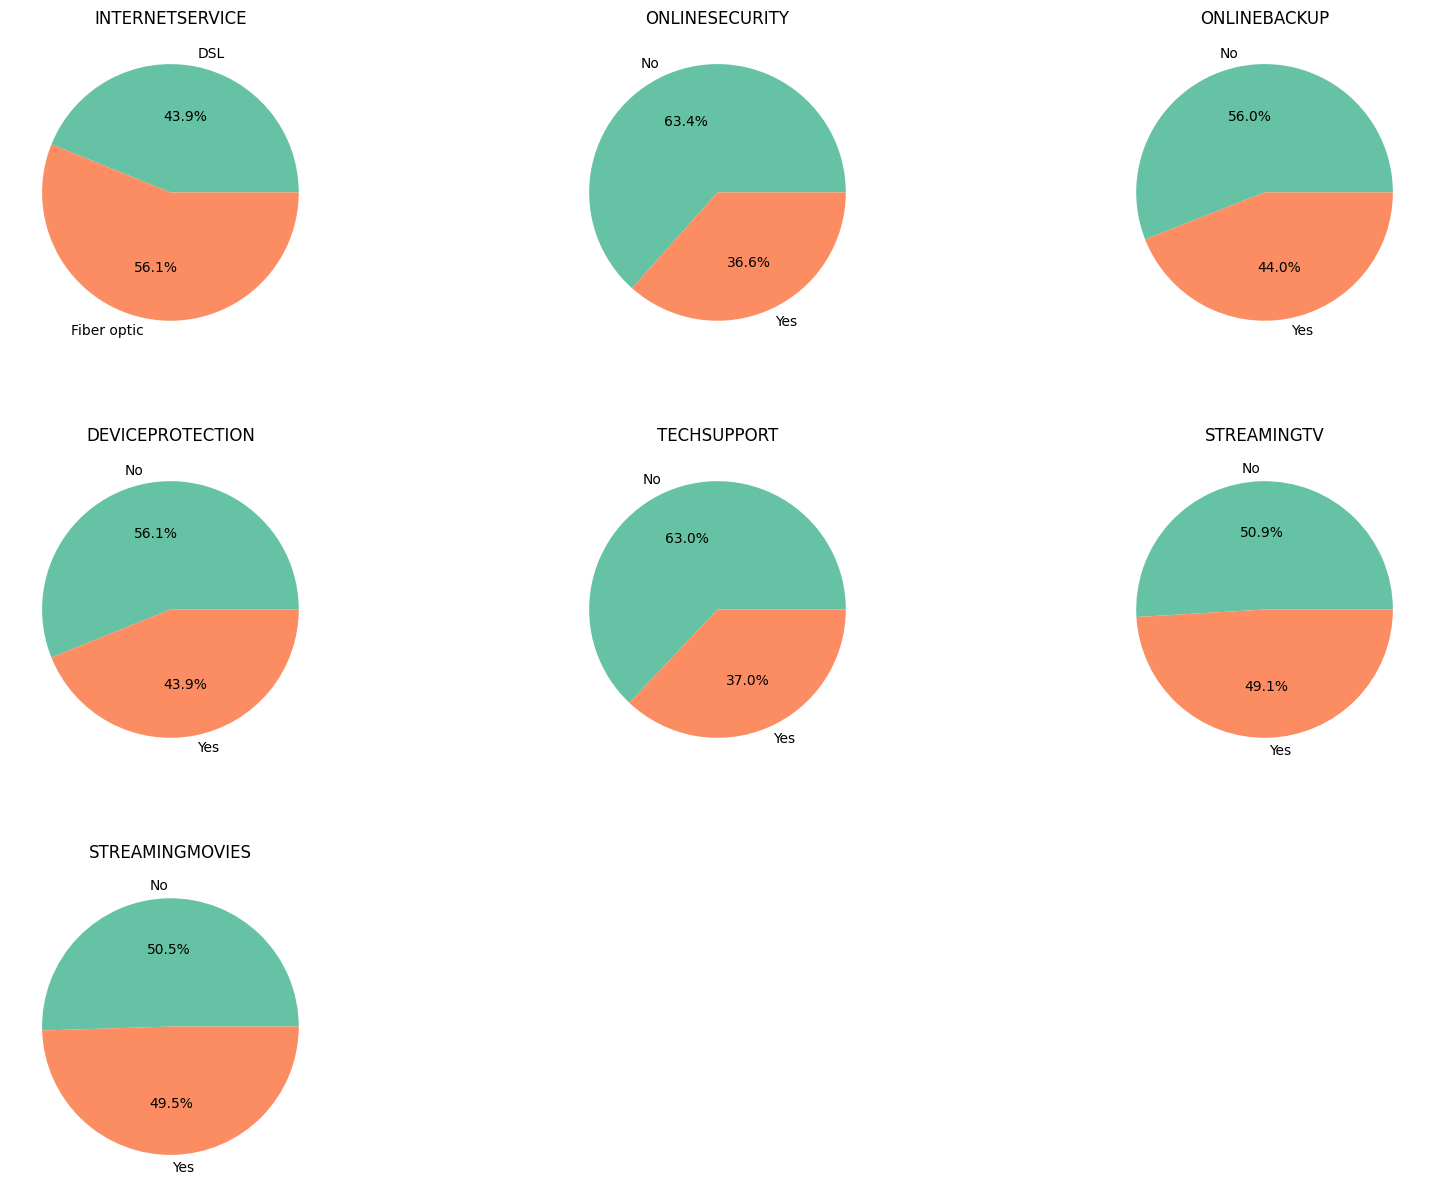

In [23]:
create_pie(internet, cat_col_internet)

Из графиков видно:
- Подключение по оптоволоконному кабелю составляет 56%
- Блокировку небезопасных сайтов подключили 37% клиентов;
- Облачное хранение поключили 44% клиентов;
- Антивирус есть у 44%
- Выделенной линией технической поддержки пользуются 37%
- Стриминговое ТВ и каталог фильмов подключили половина клиентов

### Исследовательский анализ phone

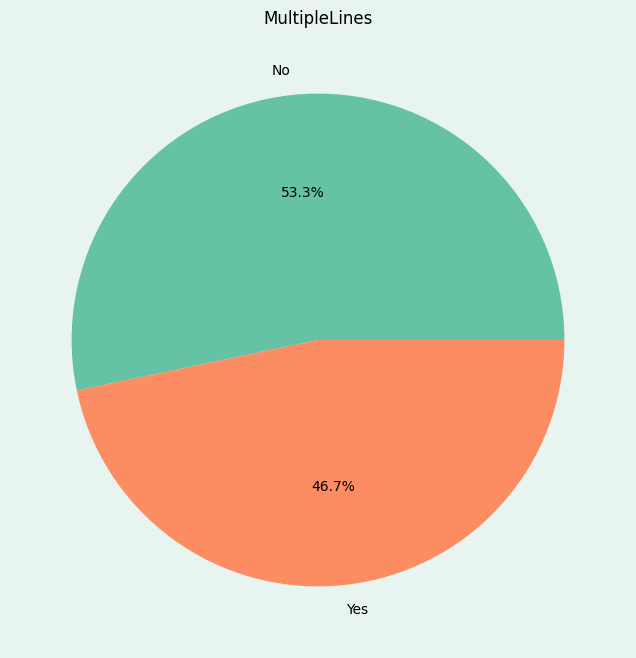

In [24]:

df_ph = phone.groupby('MultipleLines').count()
fig, ax = plt.subplots(figsize=(8,8), facecolor='#e8f4f0')
ax.pie(df_ph[df_ph.columns[-1]], labels=df_ph.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
ax.set_title('MultipleLines');
#ax.set_xlabel('MultipleLines');

Из графика видно:
- 47% подключены к нескольким телефонным линиям одновременно

## Объединение данных

In [25]:
df_merged = pd.merge(contract, personal, how='left', on='customerID')
df_merged = pd.merge(df_merged, internet, how='left', on='customerID')
df_merged = pd.merge(df_merged, phone, how='left', on='customerID')

df_merged.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

В таблице имеются пропуски, но это может быть связано с тем, что клиенты просто не используют некоторые услуги.

Заполним пропуски третьим значением "Not used"

In [26]:
df_merged.fillna('Not used', inplace=True)

df_merged.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

## Исследовательский анализ и предобработка данных объединённого датафрейма

Создадим целевой признак target, на основе информации даты окончания действия договора. Если даты нет, значит клиент не разорвал контракт (значение 0), если дата есть, значит клиент ушел (значение 1)

In [27]:
df_merged['target'] = df_merged['EndDate'].apply(lambda x: 0 if x=='No' else 1)

Изменим тип данных в столбцах с датами и добавим новый признак с количеством дней действия контракта DaysContract

In [28]:
df_merged['EndDate'].replace('No', '2020-02-01', inplace=True)

df_merged['BeginDate'] = pd.to_datetime(df_merged['BeginDate'])
df_merged['EndDate'] = pd.to_datetime(df_merged['EndDate'])

df_merged['DaysContract'] =(df_merged['EndDate'] - df_merged['BeginDate']) / np.timedelta64 ( 1 , 'D')
df_merged = df_merged.astype({'DaysContract': int})

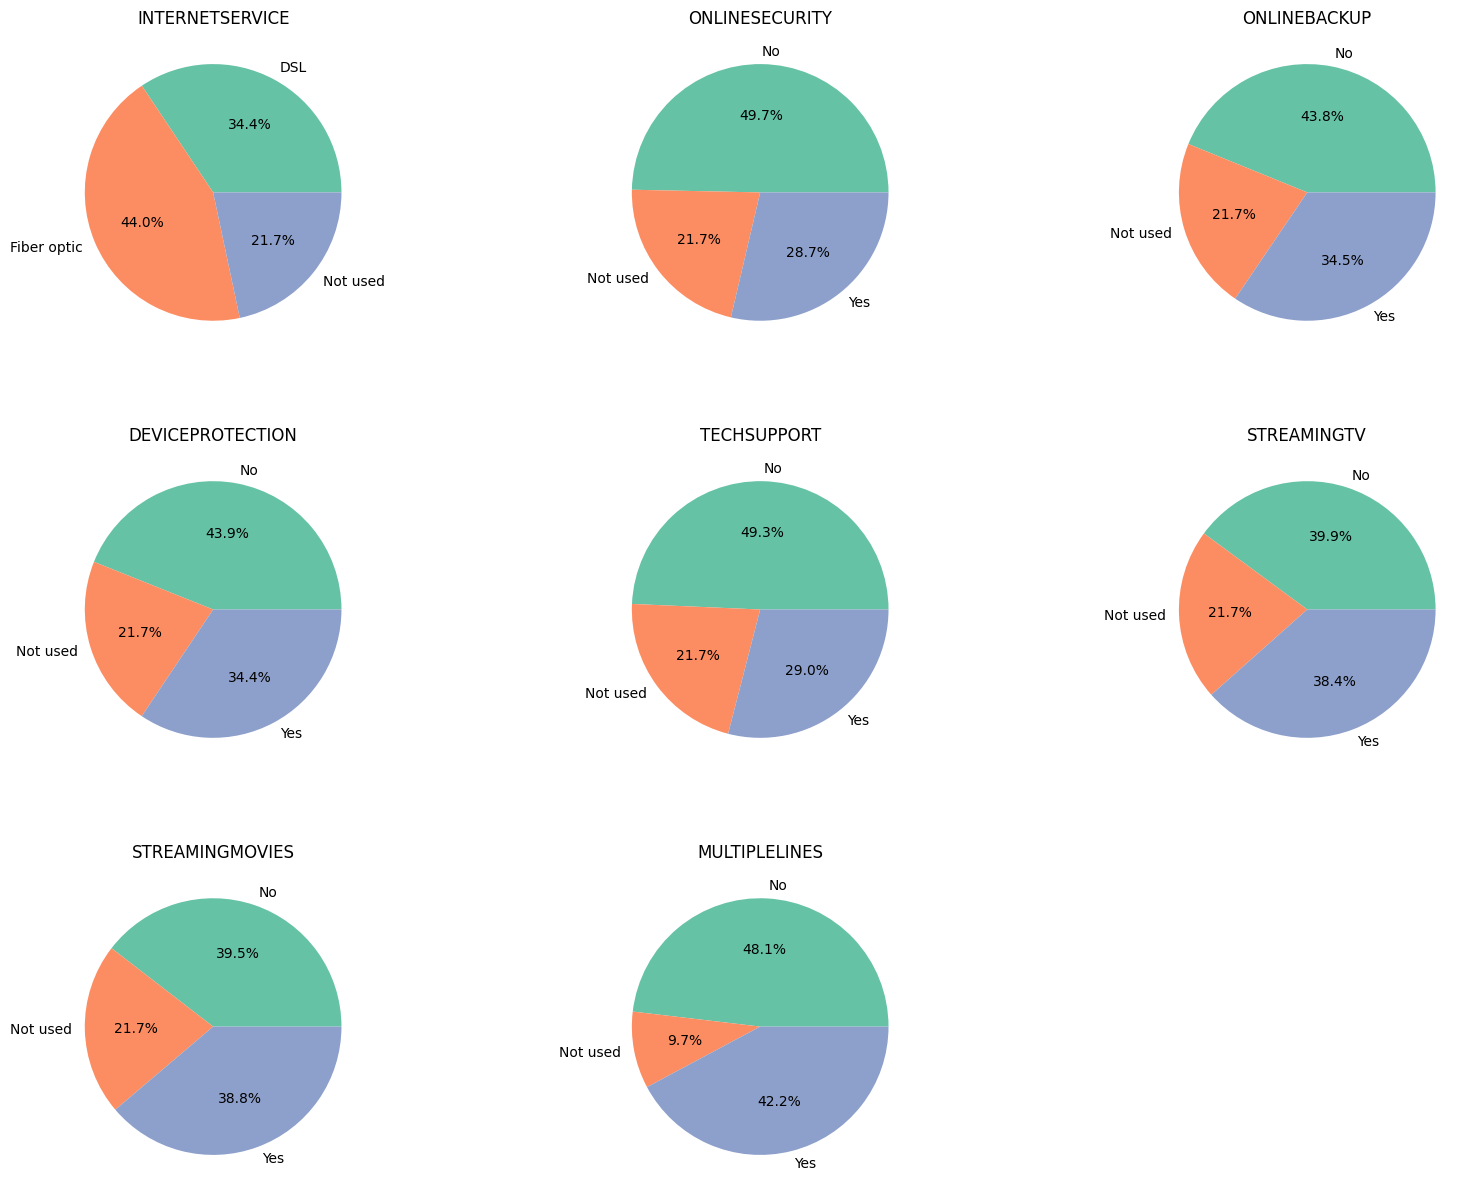

In [29]:
cat_col_internet.append('MultipleLines')
create_pie(df_merged, cat_col_internet)

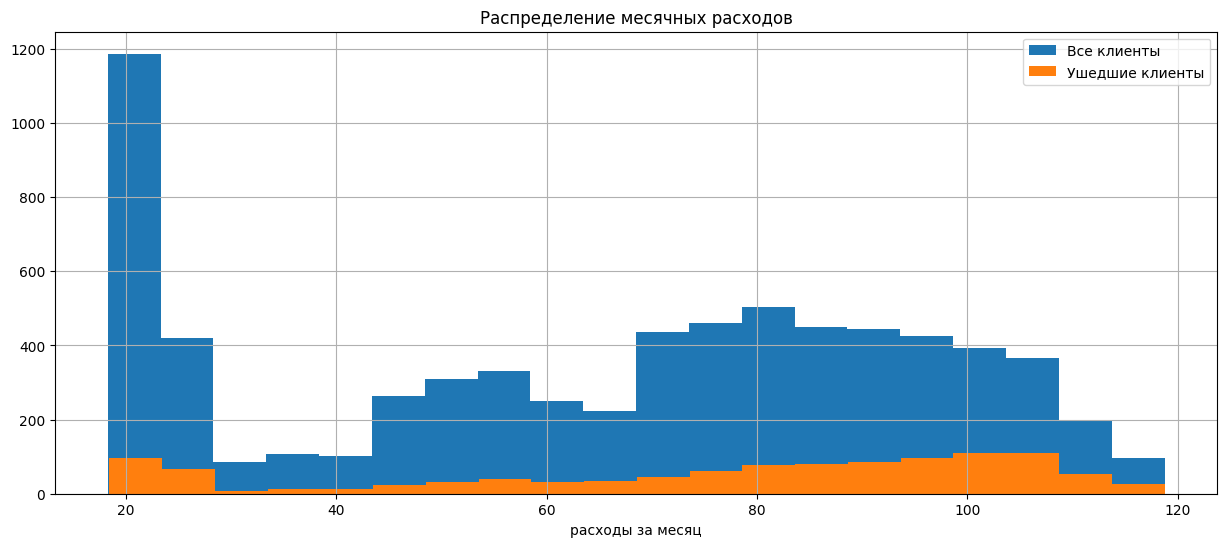

In [30]:
df_exit = df_merged[df_merged['target'] == 1]

df_merged['MonthlyCharges'].hist(bins=20, figsize=(15,6), label='Все клиенты')
df_exit['MonthlyCharges'].hist(bins=20, figsize=(15,6), label='Ушедшие клиенты')
plt.title('Распределение месячных расходов')
plt.xlabel('расходы за месяц')
plt.legend()
plt.show()

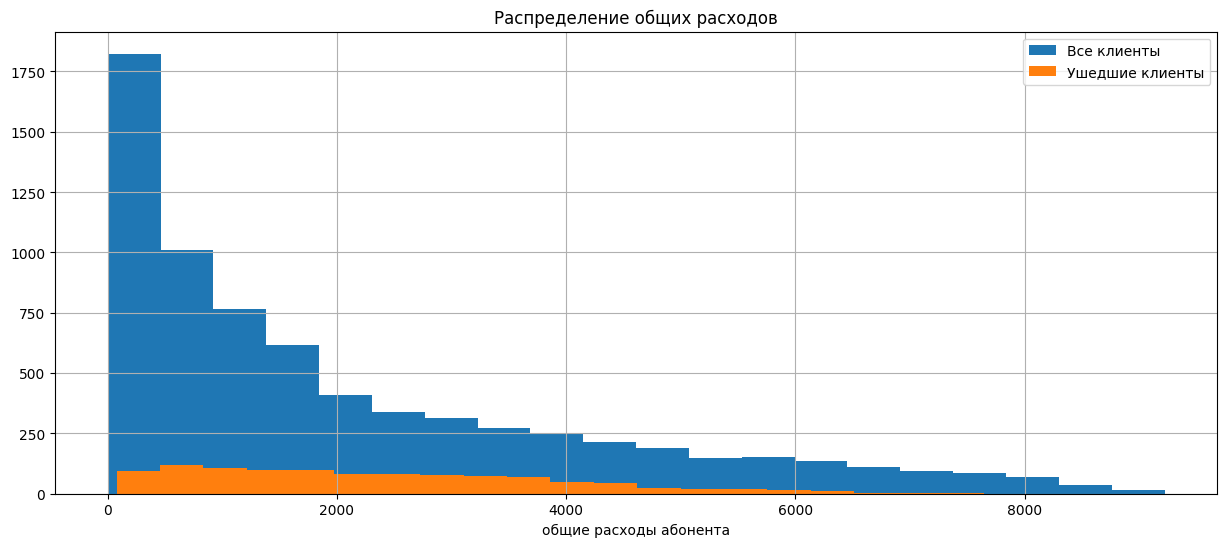

In [31]:
df_merged['TotalCharges'].hist(bins=20, figsize=(15,6), label='Все клиенты')
df_exit['TotalCharges'].hist(bins=20, figsize=(15,6), label='Ушедшие клиенты')
plt.title('Распределение общих расходов')
plt.xlabel('общие расходы абонента')
plt.legend()
plt.show()

По графикам видно, что чаще уходят клиенты с месячныи платежом в районе 20 и 100 у.е.
И тех, чьи общие расходы состовляю до 4000

In [32]:
column_to_drop = ['customerID', 'BeginDate', 'EndDate']
phik_df = df_merged.drop(column_to_drop, axis=1)

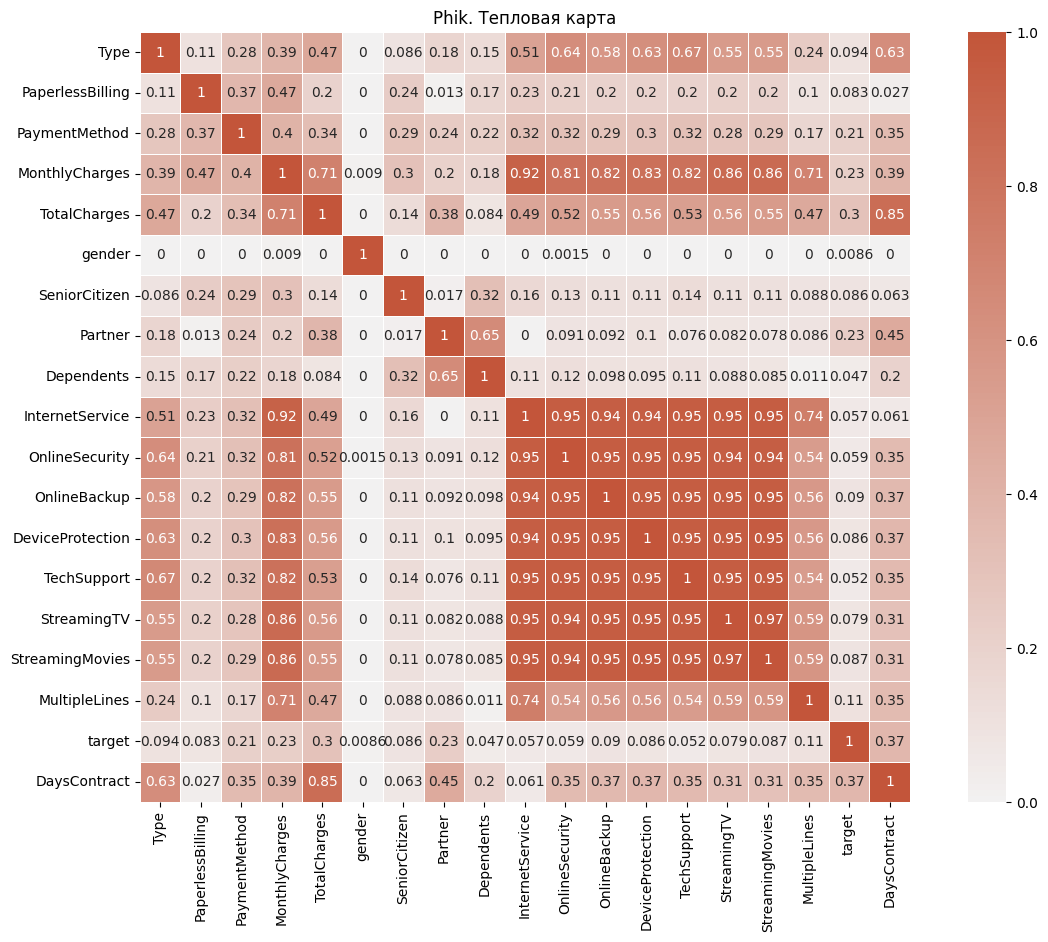

In [33]:
plot_phik_heatmap(phik_df, ['MonthlyCharges', 'TotalCharges', 'target', 'DaysContract'])

По визуализации матрицы phik видим очень высокую корреляцию между признаками с интернет услугами. Так жe видим нулевую кореляцию признака gender

Удалим gender, а вместо признаков с интернет услугами создадим новый с количесвом этих услуг у каждого клиента

In [34]:
phik_df[cat_col_internet[1:-1]] = phik_df[cat_col_internet[1:-1]].replace(['Yes', 'No', 'Not used'], [1, 0, 0])
df_merged['SumService'] = phik_df[cat_col_internet[1:-1]].sum(axis=1)

In [35]:
df_merged.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,DaysContract,SumService
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,Yes,No,No,No,No,Not used,0,31,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,Yes,No,Yes,No,No,No,No,0,1036,2
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,Yes,Yes,No,No,No,No,No,0,123,2
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,Yes,No,Yes,Yes,No,No,Not used,0,1371,3
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,No,No,No,No,No,No,0,153,0


## Подготовка данных

Удалим лишние признаки и признак с нулевой корелляцией: customerID, BeginDate, EndDate, gender

И разделим датасет на тренировочную и тестовую выборки

In [36]:
column_to_drop = ['customerID', 'BeginDate', 'EndDate', 'gender'] #'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'SeniorCitizen', 'Dependents', 'PaperlessBilling', 'InternetService']
df_merged.drop(column_to_drop, axis=1, inplace=True)

In [37]:
num_col_df = list(df_merged.drop('target', axis=1).select_dtypes(include=['int64', 'float64']).columns)
cat_col_df = list(df_merged.select_dtypes(include=['object']).columns)

In [38]:
features_train, features_test, target_train, target_test = train_test_split(
    df_merged.drop('target', axis=1), df_merged['target'], test_size=0.25, random_state=60524, stratify=df_merged['target'])

Выполним кодировку признаков. Для категориальных будем использовать OneHotEncoder, а для количественных StandardScaler

In [39]:
ohe_pipe = Pipeline([
    #('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first'))
])

numeric_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer(transformers=[
    ('ohe', ohe_pipe, cat_col_df),
    ('num', numeric_pipe, num_col_df)
], remainder='passthrough')

## Обучение моделей машинного обучения

### CatBoostClassifier

In [40]:
pipeline_catboost = Pipeline([
    ('preprocessor', data_preprocessor),
    ("catboost", CatBoostClassifier(loss_function="Logloss", iterations=800))
])

param_grid_catboost = {
    'catboost__iterations': [800],
    'catboost__learning_rate': [0.5],
    'catboost__depth':[2, 10],
    'catboost__l2_leaf_reg': [3]
}

best_params_catboost, roc_catboost, model_catboost = \
evaluate_pipeline(pipeline_catboost, param_grid_catboost, features_train, target_train)


0:	learn: 0.4584611	total: 48.4ms	remaining: 38.6s
1:	learn: 0.4077210	total: 50.7ms	remaining: 20.2s
2:	learn: 0.3774538	total: 52.3ms	remaining: 13.9s
3:	learn: 0.3643542	total: 54.1ms	remaining: 10.8s
4:	learn: 0.3564728	total: 56.2ms	remaining: 8.94s
5:	learn: 0.3495230	total: 57.9ms	remaining: 7.66s
6:	learn: 0.3440300	total: 59.8ms	remaining: 6.78s
7:	learn: 0.3399186	total: 61.3ms	remaining: 6.07s
8:	learn: 0.3388538	total: 63.2ms	remaining: 5.55s
9:	learn: 0.3373848	total: 64.8ms	remaining: 5.12s
10:	learn: 0.3356883	total: 66.5ms	remaining: 4.77s
11:	learn: 0.3345638	total: 68.3ms	remaining: 4.48s
12:	learn: 0.3332244	total: 69.8ms	remaining: 4.22s
13:	learn: 0.3320834	total: 71.3ms	remaining: 4s
14:	learn: 0.3288648	total: 73.3ms	remaining: 3.83s
15:	learn: 0.3277263	total: 75.1ms	remaining: 3.68s
16:	learn: 0.3270922	total: 77.1ms	remaining: 3.55s
17:	learn: 0.3243037	total: 78.9ms	remaining: 3.43s
18:	learn: 0.3231097	total: 80.7ms	remaining: 3.32s
19:	learn: 0.3226103	tota

### LGBMClassifier

In [41]:
pipeline_lgbm = Pipeline([
    ('preprocessor', data_preprocessor),
    ("lgbm", LGBMClassifier())
])

param_grid_lgbm = {
    'lgbm__num_leaves': [2, 10],
    'lgbm__max_depth': [3, 5]
}


best_params_lgbm, roc_lgbm, model_lgbm = \
evaluate_pipeline(pipeline_lgbm, param_grid_lgbm, features_train, target_train)


[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412


### LogisticRegression

In [42]:
pipeline_lgbm = Pipeline([
    ('preprocessor', data_preprocessor),
    ("log", LogisticRegression())
])

param_grid_lgbm = {
    'log__penalty': ['l1', 'l2'],
    'log__max_iter': [50, 100, 500]
}


best_params_log, roc_log, model_log = \
evaluate_pipeline(pipeline_lgbm, param_grid_lgbm, features_train, target_train)

In [43]:
data = {
    "model": ['catboost', 'lgbm', 'logistic'],
    "train_roc_auc": [roc_catboost, roc_lgbm, roc_log]
}

df_all_model = pd.DataFrame(data)

df_all_model.head()

,model,train_roc_auc
0,catboost,0.916277
1,lgbm,0.843014
2,logistic,0.763151


## Выбор лучшей модели

Лучшей моделью стала catboost с показателем 0.917 на обучающей выборке.

Применим ее на тестовой выборке

In [44]:
predictions = model_catboost.predict_proba(features_test)
roc_auc_test = roc_auc_score(target_test, predictions[:,1])
print('Значение метрики ROC-AUC на тестовой выборке: ', roc_auc_test)

Значение метрики ROC-AUC на тестовой выборке:  0.9300391533096781


Построим матрицу ошибок и ROC-кривую

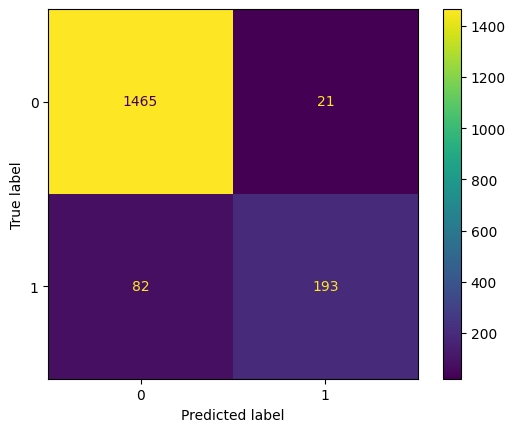

In [45]:
pred = model_catboost.predict(features_test)
cm = confusion_matrix(target_test, pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot();

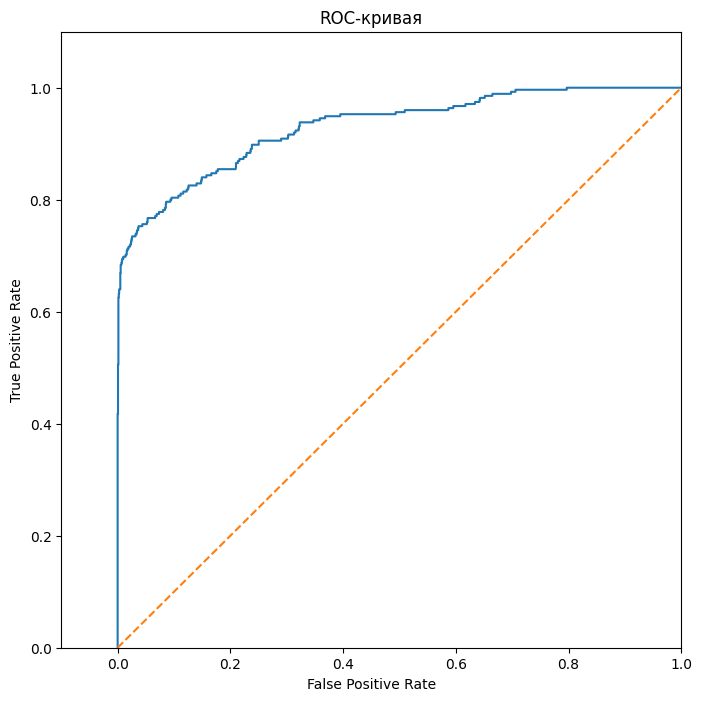

In [46]:
fpr, tpr, thresholds = roc_curve(target_test, model_catboost.predict_proba(features_test)[:, 1])

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.1,1.0])
plt.ylim([0.0,1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

По графикам видно, что наша модель в подавляющем большинстве правильно предсказывает то, что клиент останется (1465) и что клиент уйдет(193)

Построим график распеределения важности признаков

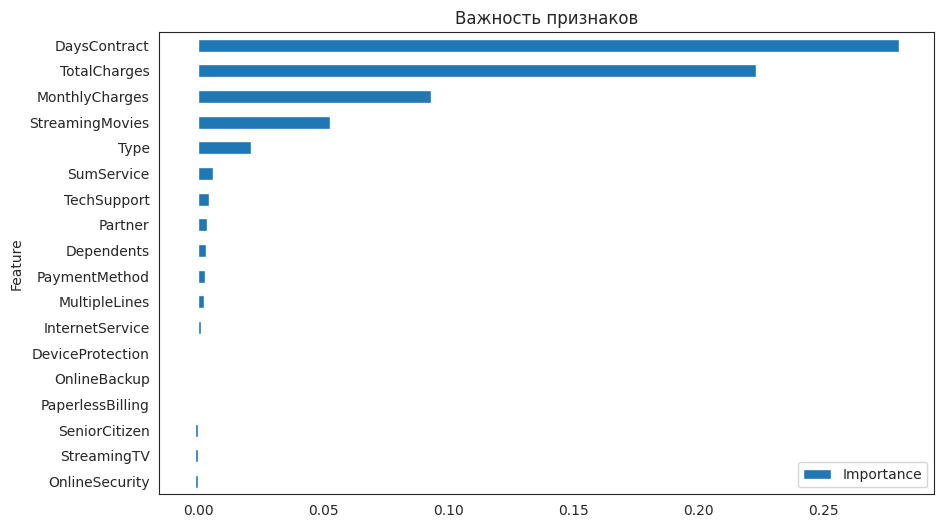

In [47]:
result = permutation_importance(model_catboost, features_test, target_test)

features_names = features_train.columns

feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));
plt.title('Важность признаков');


Наиболее важными признаками являются: количество дней кнотракта, общие и месячные платежи

## Заключение


Цель проекта: Разработать модели машинного обучения для предсказания клиентов, собирающихся разорвать контракт

Для этого мы сделали исследовательский анализ данных датафреймов, объединили их и сознали новые признаки - количество дней контракта. Заполнили пропуски в данных. Построили графики распределения признаков и матрицу корреляции.

Для предсказания уровня удовлетворенности обработали данные и выбрали лучшую модель из 3: Catboost, LGBM, LogisticRegession. Лучшей моделью оказалась Catboost со значением метрики ROC-AUC равной 0.93 на тестовой выборке, которая удовлетворяет минимальному требованию.




**Рекомендации для бизнеса:**
Возможно компании стоит обратить внимание на месячные подписки, предоставялть какие-то промокоды для клиентов, кто уже пользуется услугами какое-то время